In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sklearn здесь только, чтобы разделить выборку на тренировочную и тестовую
from sklearn.model_selection import train_test_split

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
### Шаг 1. Определение функций, которые понадобяться для обучения
# преобразование массива в бинарный вид результатов
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized

# преобразование массива в необходимый вид
def from_one_hot(Y):
    arr = np.zeros((len(Y), 1))

    for i in range(len(Y)):
        l = layer2[i]
        for j in range(len(l)):
            if(l[j] == 1):
                arr[i] = j+1
    return arr

# функции активации
def sigmoid(x): return 1/(1+np.exp(-x))

def sigmoid_deriv(x):
    return sigmoid(x)*(1 - sigmoid(x))**2

def tanh_act(x):
    return np.tanh(x)

def tanh_deriv(x):
    return 1-(np.tanh(x))**2

def relu(x):
    return x * (x > 0)

def relu_deriv(x):
    x[x<=0] = np.random.uniform(0.01, 0.05)
    x[x>0] = 1
    return x

# нормализация массива
def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)


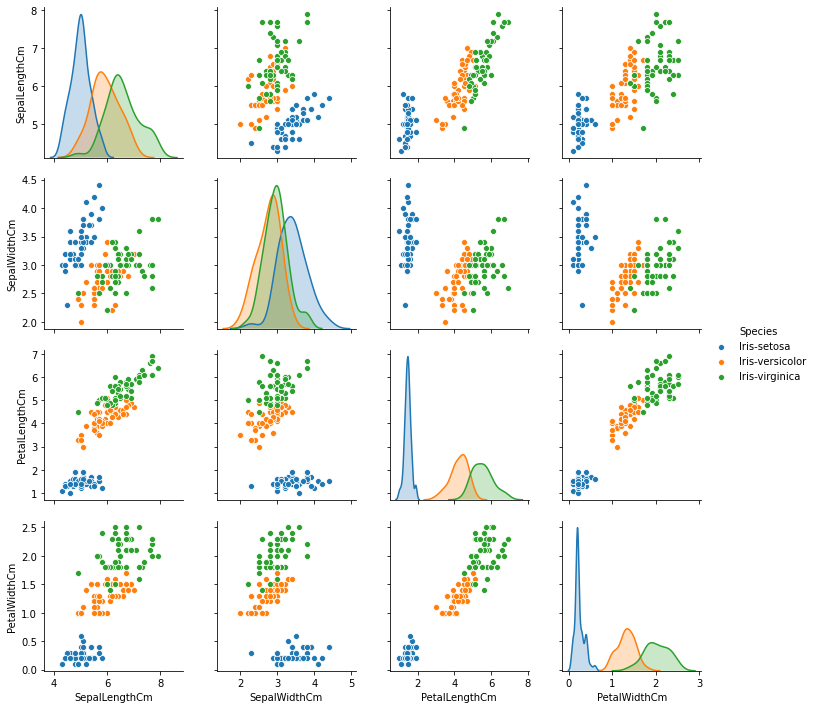

In [3]:
### Шаг 2. Подготовка тренировочных данных
# получения данных из csv файла. укажите здесь путь к файлу Iris.csv
iris_data = pd.read_csv("Iris.csv")
# print(iris_data.head()) # расскоментируйте, чтобы посмотреть структуру данных

# репрезентация данных в виде графиков
g = sns.pairplot(iris_data.drop("Id", axis=1), hue="Species")
# plt.show() # расскоментируйте, чтобы посмотреть

# замена текстовых значений на цифровые
iris_data['Species'].replace(['Iris-setosa', 'Iris-virginica', 'Iris-versicolor'], [0, 1, 2], inplace=True)

In [4]:
iris_data

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,0
1,2,4.9,3.0,1.4,0.2,0
2,3,4.7,3.2,1.3,0.2,0
3,4,4.6,3.1,1.5,0.2,0
4,5,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,1
146,147,6.3,2.5,5.0,1.9,1
147,148,6.5,3.0,5.2,2.0,1
148,149,6.2,3.4,5.4,2.3,1


In [5]:
columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
x = pd.DataFrame(iris_data, columns=columns)
x = normalize(np.array(x))

# формирование выходных данных(результатов)
columns = ['Species']
y = pd.DataFrame(iris_data, columns=columns)
y = np.array(y)
y = y.flatten()
y = to_one_hot(y)

# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

In [6]:
class NeuralNetwork:
    def __init__(self, X, Y, n, l_config, activation, deriv):
        np.random.seed(10)
        if l_config[0]!=X.shape[1] or l_config[len(l_config)-1]!=Y.shape[1] or X.shape[0]!=Y.shape[0] :
            print('Размерность входных или выходных данных не совпадают. Сеть не создана')
        else:
            self.lnum = len(l_config)
            self.snum = len(l_config)-1
            self.lw=[]
            for i in range(self.snum):
                self.lw.append(2*np.random.random((l_config[i], l_config[i+1])) - 1 )
            self.n = n # скорость обучения (learning rate)
            self.errors = [] # массив для ошибок, чтобы потом построить график
            self.ldata = [i for i in range(self.lnum)]
            self.input = X.copy()
            self.output = Y.copy()
            self.lerr = [i for i in range(self.snum)]
            self.ldelta =[i for i in range(self.snum)]
            print(f'Создана сеть: layers={self.lnum} input={self.input.shape[1]} output={self.output.shape[1]}')
            self.activation = activation
            self.deriv = deriv

        
    def feedforward(self, nn_input=None):
        # прямое распространение(feed forward)
        self.ldata =[]
        f=[]
        if nn_input is not None:
            self.input = nn_input.copy()   
        for i in range(self.lnum):
            if i==0:
                #print('feedforward yes',i)
                self.ldata.append(self.input.copy())
                f.append(i)
            else:
                self.ldata.append(self.activation(np.dot(self.ldata[i-1],  self.lw[i-1])))
                f.append(i)

        return self.ldata[self.lnum-1]

    def backprop(self):
        for i in range(self.snum-1,-1,-1):
            if i==self.snum-1:
                self.lerr[i]=self.output - self.ldata[i+1]
                self.ldelta[i]=(self.lerr[i]*self.deriv(self.ldata[i+1]))
            else:
                self.lerr[i]=self.ldelta[i+1].dot(self.lw[i+1].T)
                self.ldelta[i]=self.lerr[i]*self.deriv(self.ldata[i+1])
    
    def training(self, steps):
        iter_ = 0
        for iter_ in range(1,steps):  
            self.feedforward()
            self.backprop()
            for i in range(self.snum):

                self.lw[i] +=self.ldata[i].T.dot(self.ldelta[i]) * self.n
    
            self.errors.append(np.mean(np.abs(self.lerr[self.snum-1])))
            if (iter_ % 10000 == 0 or iter_ == 1) and iter_ != steps-1:
                print(f'iteration {iter_}  err {np.mean(np.abs(self.lerr[self.snum-1]))}')
        print(f'Stop iteration {iter_}  err {np.mean(np.abs(self.lerr[self.snum-1]))}')
            
    def predict(self, x):
        if x.shape[1] == self.input.shape[1]:  
            predict = feedforward(inpyt =x.copy())
        return predict

## Базовый алгоритм, Sigmoid, 3 слоя

In [7]:
layears_config = [4,5,3]
nn = NeuralNetwork(X_train, y_train, 0.1, layears_config, sigmoid, sigmoid_deriv)

Создана сеть: layers=3 input=4 output=3


In [8]:
nn.training(100000)

iteration 1  err 0.5040358923407656
iteration 10000  err 0.15892500813130328
iteration 20000  err 0.03822808702864031
iteration 30000  err 0.15384417824304006
iteration 40000  err 0.10414659738638177
iteration 50000  err 0.1276939811029863
iteration 60000  err 0.12520883925466578
iteration 70000  err 0.12266734688960675
iteration 80000  err 0.11861868643612486
iteration 90000  err 0.11537238212264855
Stop iteration 99999  err 0.11174880624348375


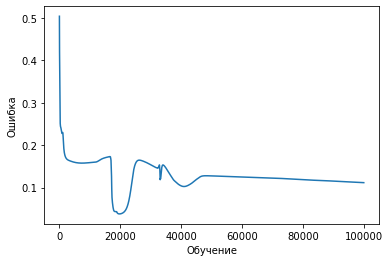

Точность нейронной сети 88.83%


In [9]:
plt.plot(nn.errors)
plt.xlabel('Обучение')
plt.ylabel('Ошибка')
plt.show() 
        
print("Точность нейронной сети " + str(round((1 - nn.errors[len(nn.errors)-1]) * 100,2)) + "%")

## Sigmoid, 4 слоя

In [10]:
layears_config = [4,6,8,3]
nn2 = NeuralNetwork(X_train, y_train, 0.001, layears_config, sigmoid, sigmoid_deriv)

Создана сеть: layers=4 input=4 output=3


In [11]:
nn2.training(100000)

iteration 1  err 0.4746072601735932
iteration 10000  err 0.43862766675597875
iteration 20000  err 0.4098991055774987
iteration 30000  err 0.28098611080263525
iteration 40000  err 0.2233257373952722
iteration 50000  err 0.2005711790611755
iteration 60000  err 0.18529630823672064
iteration 70000  err 0.1718894329458052
iteration 80000  err 0.15888091769289733
iteration 90000  err 0.14722469978615832
Stop iteration 99999  err 0.13751410011086465


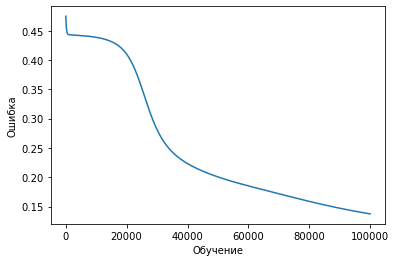

Точность нейронной сети 86.25%


In [12]:
plt.plot(nn2.errors)
plt.xlabel('Обучение')
plt.ylabel('Ошибка')
plt.show() 
        
print("Точность нейронной сети " + str(round((1 - nn2.errors[len(nn2.errors)-1]) * 100,2)) + "%")

### Оставим 4 слоя и поменяем функцию активации на TANH 

In [13]:
layears_config = [4,7,9,3]
nn3 = NeuralNetwork(X_train, y_train, 0.001, layears_config, tanh_act, tanh_deriv)

Создана сеть: layers=4 input=4 output=3


In [14]:
nn3.training(100000)

iteration 1  err 0.48041942441119817
iteration 10000  err 0.06396341295152773
iteration 20000  err 0.04643816290370685
iteration 30000  err 0.03843496000963088
iteration 40000  err 0.03514428927852739
iteration 50000  err 0.034418549850607515
iteration 60000  err 0.034341966625836745
iteration 70000  err 0.03444719745751724
iteration 80000  err 0.034621097210677666
iteration 90000  err 0.03484547381297098
Stop iteration 99999  err 0.03531955805438363


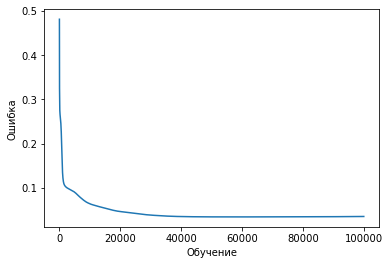

Точность нейронной сети 96.47%


In [15]:
plt.plot(nn3.errors)
plt.xlabel('Обучение')
plt.ylabel('Ошибка')
plt.show() 
        
print("Точность нейронной сети " + str(round((1 - nn3.errors[len(nn3.errors)-1]) * 100,2)) + "%")

### Оставим 4 слоя и поменяем функцию активации на Relu

In [16]:
layears_config = [4,7,9,3]
nn4 = NeuralNetwork(X_train, y_train, 0.001, layears_config, relu, relu_deriv)

Создана сеть: layers=4 input=4 output=3


In [17]:
nn4.training(100000)

iteration 1  err 0.38281486995205916
iteration 10000  err 0.17352719791710797
iteration 20000  err 0.16430617386025995
iteration 30000  err 0.16997774505830188
iteration 40000  err 0.1702687947180919
iteration 50000  err 0.1841822824776626
iteration 60000  err 0.16112296405744844
iteration 70000  err 0.14995057234874315
iteration 80000  err 0.1418969190946711
iteration 90000  err 0.13089903820038928
Stop iteration 99999  err 0.12008292520107573


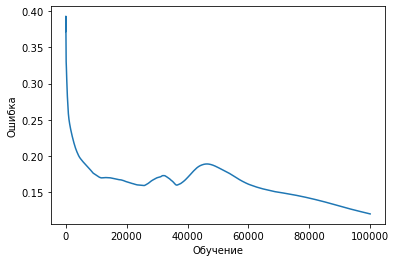

Точность нейронной сети 87.99%


In [18]:
plt.plot(nn4.errors)
plt.xlabel('Обучение')
plt.ylabel('Ошибка')
plt.show() 
        
print("Точность нейронной сети " + str(round((1 - nn4.errors[len(nn4.errors)-1]) * 100,2)) + "%")

# Введем RANDOM в разбиение датасета.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=49)

## Базовый алгоритм, Sigmoid, 3 слоя

In [20]:
layears_config = [4,5,3]
nn = NeuralNetwork(X_train, y_train, 0.1, layears_config, sigmoid, sigmoid_deriv)

Создана сеть: layers=3 input=4 output=3


In [21]:
nn.training(100000)

iteration 1  err 0.5064028024023363
iteration 10000  err 0.15395374399313586
iteration 20000  err 0.11842622334755419
iteration 30000  err 0.11060148276196599
iteration 40000  err 0.12318835003529247
iteration 50000  err 0.12122107407983364
iteration 60000  err 0.11898708402102684
iteration 70000  err 0.11807838196374935
iteration 80000  err 0.11746065144728175
iteration 90000  err 0.11714101740129716
Stop iteration 99999  err 0.11694704053167806


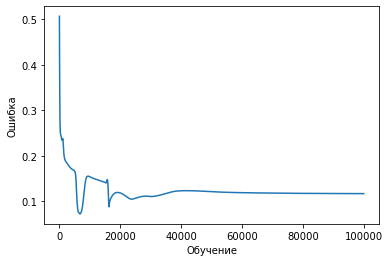

Точность нейронной сети 88.31%


In [22]:
plt.plot(nn.errors)
plt.xlabel('Обучение')
plt.ylabel('Ошибка')
plt.show() 
        
print("Точность нейронной сети " + str(round((1 - nn.errors[len(nn.errors)-1]) * 100,2)) + "%")

## Sigmoid, 4 слоя

In [23]:
layears_config = [4,6,8,3]
nn2 = NeuralNetwork(X_train, y_train, 0.001, layears_config, sigmoid, sigmoid_deriv)

Создана сеть: layers=4 input=4 output=3


In [24]:
nn2.training(100000)

iteration 1  err 0.47546168302832464
iteration 10000  err 0.43780217975900315
iteration 20000  err 0.41244688420288833
iteration 30000  err 0.2895823555937468
iteration 40000  err 0.2287508967619605
iteration 50000  err 0.2062615098909639
iteration 60000  err 0.19115728589218675
iteration 70000  err 0.17774026797747502
iteration 80000  err 0.16456829485535518
iteration 90000  err 0.15314581933967944
Stop iteration 99999  err 0.14476007575839325


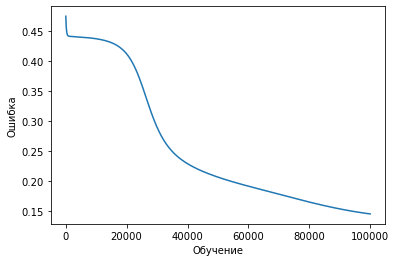

Точность нейронной сети 85.52%


In [25]:
plt.plot(nn2.errors)
plt.xlabel('Обучение')
plt.ylabel('Ошибка')
plt.show() 
        
print("Точность нейронной сети " + str(round((1 - nn2.errors[len(nn2.errors)-1]) * 100,2)) + "%")

### Оставим 4 слоя и поменяем функцию активации на TANH 

In [26]:
layears_config = [4,7,9,3]
nn3 = NeuralNetwork(X_train, y_train, 0.001, layears_config, tanh_act, tanh_deriv)

Создана сеть: layers=4 input=4 output=3


In [27]:
nn3.training(100000)

iteration 1  err 0.4790161684958929
iteration 10000  err 0.05994284320821436
iteration 20000  err 0.04362756883702616
iteration 30000  err 0.03302622876114927
iteration 40000  err 0.030744656845430707
iteration 50000  err 0.029444804750860646
iteration 60000  err 0.029049988925012656
iteration 70000  err 0.028573928826509137
iteration 80000  err 0.02808732010370627
iteration 90000  err 0.027663720778422808
Stop iteration 99999  err 0.027406275818495952


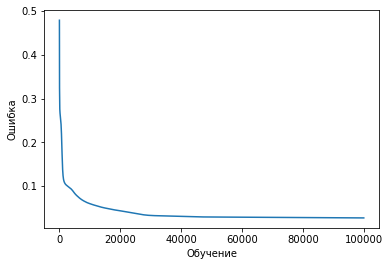

Точность нейронной сети 97.26%


In [28]:
plt.plot(nn3.errors)
plt.xlabel('Обучение')
plt.ylabel('Ошибка')
plt.show() 
        
print("Точность нейронной сети " + str(round((1 - nn3.errors[len(nn3.errors)-1]) * 100,2)) + "%")

### Оставим 4 слоя и поменяем функцию активации на Relu

In [29]:
layears_config = [4,7,9,3]
nn4 = NeuralNetwork(X_train, y_train, 0.001, layears_config, relu, relu_deriv)

Создана сеть: layers=4 input=4 output=3


In [30]:
nn4.training(100000)

iteration 1  err 0.3767204329589562
iteration 10000  err 0.1741171685001059
iteration 20000  err 0.16751124813522264
iteration 30000  err 0.14797468866292499
iteration 40000  err 0.12414440582930723
iteration 50000  err 0.10147771004703465
iteration 60000  err 0.1229314721318284
iteration 70000  err 0.14290750867039884
iteration 80000  err 0.13309403997368002
iteration 90000  err 0.12359135746070544
Stop iteration 99999  err 0.11687244694961967


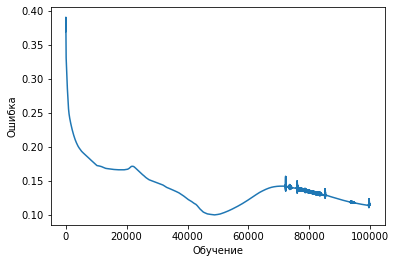

Точность нейронной сети 88.31%


In [31]:
plt.plot(nn4.errors)
plt.xlabel('Обучение')
plt.ylabel('Ошибка')
plt.show() 
        
print("Точность нейронной сети " + str(round((1 - nn4.errors[len(nn4.errors)-1]) * 100,2)) + "%")

<b>1. Попробуйте видоизменить параметры разобранной на уроке двухслойной нейронной сети таким образом, чтобы улучшить ее точность. Проведите анализ — что приводит к ухудшению точности нейронной сети? Что приводит к увеличению ее точности? </b>

 Исходный результат - 88.83%

1. Видно, что количество итераций и скорость обучения - влияют на результат, преймущественно улучшают. 

2. Функция активации ReLU (x * (x > 0)) - для самой функции, а для её производной 
    x[x>0] = 1, 
    x[x<=0] = 0 <br>
 дает не плохой результат, но сильно скачет точность при обучении, пока не ясно почему

3. Количество слоев могут улучшать качетсво, но потребует более длительного обученияодин слой. Подбор нужного количества не очевиден

4. Применнение  функцию активации гиперболический тангенс дает максимальный результат при прочих равных 97.26%. нужно бы уточнить с чем это связано

5. Может сказываться на качестве  начальная стартовая инициализация вестов  и то, в каком порядки скармливать обучающие  данные 